In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

In [2]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

In [3]:
tmp = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

median_rating = tmp['averageRating'].median()

In [4]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=5):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)

tmp['ReleaseYearRange'] = tmp['Movie release date'].apply(lambda x: create_range(x))

In [5]:
display(tmp)

,,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,awards,nominations,movie_count,movie_count_genre,genres_b4,isMale,age_at_release,averageRating,ReleaseYearRange
,IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,,
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,1974,0,0,5,3,17,0,27,4.9,2000 - 2005
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,1974,0,0,1,1,2,0,21,5.9,1995 - 2000
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge,1974,0,0,3,2,5,0,24,4.5,1995 - 2000
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge,1974,0,0,3,2,5,0,24,5.2,1995 - 2000
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge,1974,0,0,4,3,10,0,26,5.1,2000 - 2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27610,tt0120514,nm0000410,1,1191380,Wilde,1997,Stephen Fry,1957,0,0,1,0,1,1,40,6.9,1995 - 2000
27611,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr,1949,0,0,1,0,1,1,41,5.3,1990 - 1995
27612,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek,1896,0,0,1,0,11,<NA>,60,6.8,1955 - 1960


ValueError: Could not interpret value `Category` for `hue`. An entry with this name does not appear in `data`.

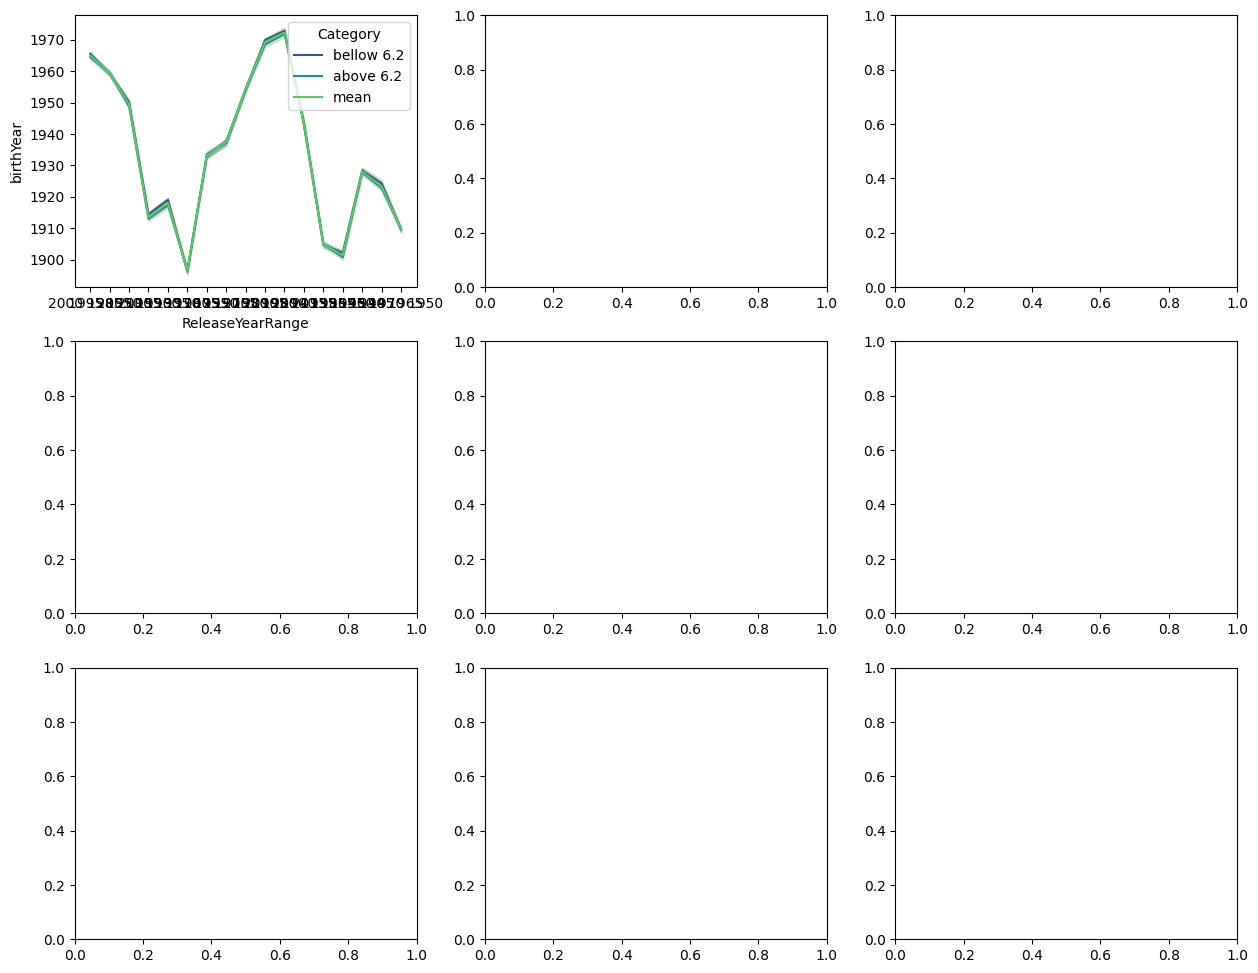

In [39]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)  # Ceiling division to determine number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    df = df.replace("\\N", pd.NA)

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        me_filtered_mean['Category'] = 'mean'

        frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

do_fancy_ecpi_cute_plot(tmp, 'median_rating', 'averageRating', 'ReleaseYearRange', 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['birthYear', 'awards', 'nominations', 'movie_count', 'movie_count_genre', 'genres_b4', 'isMale', 'age_at_release'])